In [61]:
!pip install einops
!pip install tslearn
%load_ext autoreload
%autoreload 2

import seaborn as sns
# from dataclasses import dataclass
from dataclasses import dataclass, field
import matplotlib.pyplot as plt

import datautils
from utils import init_dl_program
from hdst import HDST
import torch
import gc
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Args Configuration Class

In [62]:
@dataclass
class Args:
    task_weights: dict
    dataset: str = ""
    loader: str = ""
    gpu: int = 0
    static_repr_dims: int = 128
    dynamic_repr_dims: int = 128
    epochs: int = 200

    run_name: str = ""
    batch_size: int = 128
    lr: float = 0.001
    max_train_length = 800
    iters: int = None
    save_every = None
    seed: int = 1234
    max_threads = None
    eval: bool = True
    irregular = 0

    sample_size: int = 20
    # window_size: int = 10
    window_size: str = "Auto"
    # window_size: list = field(default_factory=lambda: [20, 50, 100, 200, 400, 800])
    distance: str = "mcc"
    top_k: int =3 # Use the top k prominent periodicity as time scale. If use sepcified window size, you can set top_k as random number.

## Instantiate Args Configuration Class
Create an instance of arguments, specifying the necessary arguments and those important to your use case.

In [63]:
args = Args(
    static_repr_dims=128,
    dynamic_repr_dims=128,
    task_weights={
        'local_static_contrast': 0.9,
        'global_vatiant_contrast': 0.00,
        'dynamic_trend_pred': 0.1,
    },
    eval=False
)

device = init_dl_program(args.gpu, seed=args.seed, max_threads=args.max_threads)
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# device="cpu"

## Load your data
You can use any data, as long as it is an `np.ndarray` of shape $(N, T, C)$ where $N$ is the number of time-series instances, $T$ the number of timesteps per instance, and $C$ the number of channels.
Choosing from 'ETTh1', 'ETTh2', 'ETTm1' and 'ETTm2'

In [64]:
data, train_slice, valid_slice, test_slice, scaler, pred_lens, tmp_stamp = datautils.load_forecast_csv("ETTh1")
# print(data.shape)
# print(tmp_stamp.shape)
train_data = data[:, train_slice]
test_data = data[:, test_slice]
train_tmp = tmp_stamp[train_slice,:]
test_tmp = tmp_stamp[test_slice,:]
train_tmp=np.expand_dims(train_tmp, axis=0)
test_tmp=np.expand_dims(test_tmp, axis=0)
tmp_stamp=np.expand_dims(tmp_stamp, axis=0)
n_channels=train_data.shape[2]
print(f"Shapes - train data: {train_data.shape}, test data: {test_data.shape}")
print(f"Shapes - train tmp: {train_tmp.shape}, test tmp: {test_tmp.shape}")
train_all=np.concatenate((train_data,train_tmp),axis=2)
test_all=np.concatenate((test_data,test_tmp),axis=2)
data_all=np.concatenate((data,tmp_stamp),axis=2)
print(f"Shapes - train all: {train_all.shape}, test all: {test_all.shape}")
print(f"Shapes - data all: {data_all.shape}")
print(pred_lens)
print(n_channels)
print(train_data.size)

Shapes - train data: (1, 8640, 7), test data: (1, 2880, 7)
Shapes - train tmp: (1, 8640, 5), test tmp: (1, 2880, 5)
Shapes - train all: (1, 8640, 12), test all: (1, 2880, 12)
Shapes - data all: (1, 17420, 12)
[24, 48, 168, 336, 720]
7
60480


In [65]:
from torch.utils.data import TensorDataset, DataLoader
from utils import FFT_for_Period
train_data_temp = (torch.from_numpy(train_data).to(torch.float))
scale_list, scale_weight = FFT_for_Period(train_data_temp, 5)
print(scale_list)

[8640]


## Create and Train the model

In [66]:
sns.set_theme()
torch.cuda.empty_cache()
gc.collect()

3635

In [67]:
import time
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

start_time = time.time()
model = HDST(
    input_dims=train_data.shape[-1],
    device=device,
    task_weights=args.task_weights,
    batch_size=args.batch_size,
    lr=args.lr,
    output_dims1=args.static_repr_dims,
    output_dims2=args.dynamic_repr_dims,
    max_train_length=args.max_train_length
)

loss_log = model.fit(
    train_all,
    n_epochs=args.epochs,
    n_iters=args.iters,
    k=args.sample_size,
    w=args.window_size,
    distance=args.distance,
    top_k=args.top_k,
    n_channels=n_channels
)
end_time = time.time()
training_time = end_time - start_time
print(f"Model training time: {training_time:.2f} seconds")

Training data shape: (10, 864, 7)
Scale list: [24, 864, 432]


Training: 100%|██████████| 200/200 [00:52<00:00,  3.80it/s, epoch=200, loss=0.634]

Model training time: 52.71 seconds


Save model and loss log

In [68]:
# # import torch
# # torch.save(model, 'logs/mymodel_ETTh1.pth')
# import pandas as pd
# df = pd.DataFrame({"epoch": list(range(1, len(loss_log) + 1)), "loss": loss_log})
# df.to_csv("logs/loss_log_ETTh1.csv", index=False)

Visualize the loss curve and save figure

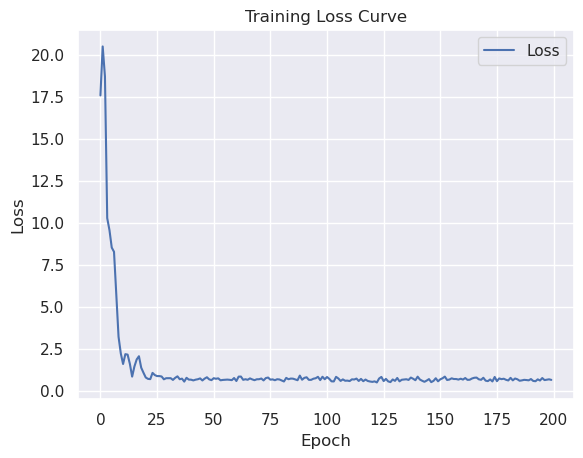

In [69]:
import matplotlib.pyplot as plt
# print(loss_log)
plt.plot(loss_log, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

## Test the model
Firstly, get the representation of training data and test data using `model.encode`. Then train a Ridge regression model using training representation and corresponding training labels. Finally, use the Ridge regression model to do forecasting for test representation. Report the MSE and MAE.

In [70]:
from tasks.forecasting import eval_forecasting
out, eval_res = eval_forecasting(
                model,
                data_all,
                n_channels,
                train_slice,
                valid_slice,
                test_slice,
                scaler,
                pred_lens
            )
res=eval_res['ours']
for key, value in res.items():
    print(f"{key}: {value}")


24: {'norm': {'MSE': 0.4668220583865774, 'MAE': 0.47395596339355855}, 'raw': {'MSE': 8.166817007025644, 'MAE': 1.641269312070661}}
48: {'norm': {'MSE': 0.5083957057835479, 'MAE': 0.5035888694481425}, 'raw': {'MSE': 9.303491682856649, 'MAE': 1.7806262191591429}}
168: {'norm': {'MSE': 0.6527614575654381, 'MAE': 0.5943583398603878}, 'raw': {'MSE': 11.847445652732514, 'MAE': 2.093071637111879}}
336: {'norm': {'MSE': 0.8323140896198723, 'MAE': 0.688612922517802}, 'raw': {'MSE': 12.951967530733432, 'MAE': 2.2766386998076236}}
720: {'norm': {'MSE': 1.0181017314283338, 'MAE': 0.7938865247565134}, 'raw': {'MSE': 14.992318891210354, 'MAE': 2.6099911355180483}}
